# Causal Analysis of Census Dataset
Analyzing for bias on the randomly generated test data

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import random
import seaborn as sns
from pymatch.Matcher import Matcher
from pymatch.functions import ks_boot
from joblib import Parallel, delayed

from utils import treatment_effect

sns.set_context("notebook")
%matplotlib inline

random.seed(0)
np.random.seed(0)

TREATMENT_COL = 'sex'
treatment_subdimensions = []
TREATMENT_VAL = 'Female'

OUTCOME_NAME = 'prediction'

CONT_COVARIATES = ['age', 'educationnum', 'capitalgain', 'capitalloss', 'hoursperweek']

TREATMENT = 'T'
OUTCOME = 'O'

In [2]:
dataset = pd.read_csv('data/census-random-prediction-rf-sex.csv', index_col=0)
dataset['prediction'] = dataset['prediction'] == '>50K'
dataset.columns = dataset.columns.str.replace('-','')
dataset.head()

,age,workclass,education,educationnum,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,nativecountry,prediction
0,54,Local-gov,9th,14,Separated,Protective-serv,Wife,Other,Male,6514,1977,95,?,True
1,55,Without-pay,Masters,3,Married-spouse-absent,Sales,Unmarried,Black,Female,3781,1735,10,India,False
2,85,State-gov,11th,6,Married-AF-spouse,Armed-Forces,Other-relative,White,Female,7443,2174,65,Laos,False
3,31,Federal-gov,Assoc-voc,11,Widowed,Handlers-cleaners,Unmarried,Amer-Indian-Eskimo,Male,4064,419,84,Peru,False
4,40,Local-gov,Doctorate,14,Separated,Sales,Unmarried,Black,Female,3781,1980,87,Dominican-Republic,False


In [3]:
# Introduce binary treatment column as proposed by Data X-Ray
dataset[TREATMENT] = dataset[TREATMENT_COL] == TREATMENT_VAL
dataset.rename({OUTCOME_NAME: OUTCOME}, axis=1, inplace=True)
dataset.head()

COVARIATES = dataset.drop([TREATMENT, OUTCOME, TREATMENT_COL] + treatment_subdimensions, axis=1).columns.values
CAT_COVARIATES = list(c for c in COVARIATES if c not in CONT_COVARIATES)

## Analysis with Matching and Propensity Score Stratification

In [4]:
dataset.columns

Index(['age', 'workclass', 'education', 'educationnum', 'maritalstatus',
       'occupation', 'relationship', 'race', 'sex', 'capitalgain',
       'capitalloss', 'hoursperweek', 'nativecountry', 'O', 'T'],
      dtype='object')

In [5]:
match_vars = []
att = treatment_effect.match_then_stratify(dataset, match_vars, TREATMENT, TREATMENT_COL, treatment_subdimensions,
                                           OUTCOME, CONT_COVARIATES, CAT_COVARIATES)
att

Training model 1/50
Training model 2/50
Training model 3/50
Training model 4/50
Training model 5/50
Training model 6/50
Training model 7/50
Training model 8/50
Training model 9/50
Training model 10/50
Training model 11/50
Training model 12/50
Training model 13/50
Training model 14/50
Training model 15/50
Training model 16/50
Training model 17/50
Training model 18/50
Training model 19/50
Training model 20/50
Training model 21/50
Training model 22/50
Training model 23/50
Training model 24/50
Training model 25/50
Training model 26/50
Training model 27/50
Training model 28/50
Training model 29/50
Training model 30/50
Training model 31/50
Training model 32/50
Training model 33/50
Training model 34/50
Training model 35/50
Training model 36/50
Training model 37/50
Training model 38/50
Training model 39/50
Training model 40/50
Training model 41/50
Training model 42/50
Training model 43/50
Training model 44/50
Training model 45/50
Training model 46/50
Training model 47/50
Training model 48/50
T

C:\Users\Amnesix\DOCUME~1\KIT---~1\00-AUS~1\Studium\WINTER~1\CAUSAL~1\mldcpy\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Covariate race not balanced enough in stratum 2. chi2-statistic: 11.93370695821981 > 9.487729036781154, p-value 0.017851106319680028


-0.04653614208958079

#### Get statistical significance by comparing with placebo treatment

In [6]:
n_iter = 50
placebo_results = treatment_effect.generate_placebo_effects(dataset, match_vars, TREATMENT, TREATMENT_COL, treatment_subdimensions,
                                                            OUTCOME, CONT_COVARIATES, CAT_COVARIATES, additional_excludes=excludes, n_iter=n_iter)

In [7]:
treatment_effect.check_treatment_effect(att, placebo_results)

Treatment effect outside 95%-bounds of placebo effect: -0.04653614208958079 not in [-0.017432708696277135, 0.01306886037059166]


In [8]:
treatment_results = Parallel(n_jobs=4)(delayed(treatment_effect.match_then_stratify)(dataset.sample(frac=.7), match_vars, TREATMENT, TREATMENT_COL, 
                                                                                     treatment_subdimensions, OUTCOME, CONT_COVARIATES, CAT_COVARIATES, 
                                                                                     n_models=1) for _ in  range(n_iter))

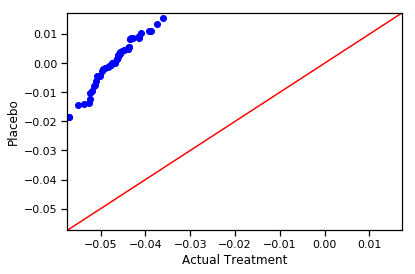

In [9]:
# QQ-Plot to compare empirical distributions.
from statsmodels.graphics.gofplots import qqplot_2samples
import pylab
import matplotlib.pyplot as plt

f = qqplot_2samples(np.array(placebo_results), np.array(treatment_results), xlabel='Actual Treatment', ylabel='Placebo', line='45')

plt.savefig("report/figures/qqML.pdf", bbox_inches='tight')

In [10]:
treatment_effect.ks_test_treatment_effect(placebo_results, treatment_results, n_iter, alpha=0.05)

Rejecting hypothesis that placebo treatment and actual treatment are of same distribution (K-S statistic: 1.0, p-value: 2.16468817146063e-23)
